<h1> PyTorch Classification with MLP </h1>
Lets see how we can train our first neural network using the Pytorch funcunalities we have previously seen! In this notebook we will be training a Multilayer Perceptron (MLP) with the MNIST dataset. We will see how to use Pytorch inbuilt datasets, how to construct a MLP using the Pytorch nn.module class and how to construct a training and testing loop to perform stochastic gradient descent (SGD).

<img src="MNIST.gif" width="700" align="center">

Animation of MNIST digits and a MLP's activations changing via learning

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
import torchvision

import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

<h2> Download the MNIST Train and Test set </h2>
The MNIST dataset is a large database of handwritten digits that is commonly used for training and testing in the field of machine learning, it consists of 60,000 training images and 10,000 testing images as well as the corresponding digit class (0-9) (it has moved out of fashion these days because it is "too easy" to learn though it is still used at times as a "proof of concept").  <br>
Pytorch has constructed a number of "dataset" classes that will automatically download various datasets making it very easy for us to train our models. We will look more closely at using Pytorch datasets in a later lab.

[Pytorch Datasets](https://pytorch.org/docs/stable/torchvision/datasets.html)

In [2]:
#Create a train and test dataset using the Pytorch MNIST dataloader class
train = MNIST('./data', train=True,  download=True, transform=transforms.ToTensor())
test  = MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

#Using the Pytorch dataloader class and the Pytorch datasets we with create itterable dataloader objects
train_loader = dataloader.DataLoader(train, shuffle=True, batch_size=256, num_workers=0, pin_memory=True) 
test_loader = dataloader.DataLoader(test, shuffle=True, batch_size=256, num_workers=0, pin_memory=True)

#NOTE:num_workers is the number of threads the dataloader will spawn to load the data from file, 
#you will rarely need more than 4

#NOTE:pin_memory is only useful if you are training with a GPU, if it is True then the GPU will pre-allocate
#memory for the NEXT batch so the CPU-GPU transfer can be handled by the DMA controller freeing up the CPU

In [3]:
#Set device to GPU_indx if GPU is avaliable
GPU_indx = 0
device = torch.device(GPU_indx if torch.cuda.is_available() else 'cpu')

<h3> Visualise a few training samples </h3>
Lets visualise that mini-batches that the dataloader gives us

In [4]:
#We can create an itterater using the dataloaders and take a random sample 
images, labels = next(iter(train_loader))
print("The input data shape is :\n", images.shape)
print("The target output data shape is :\n", labels.shape)

The input data shape is :
 torch.Size([256, 1, 28, 28])
The target output data shape is :
 torch.Size([256])


We can see that (as specified) our mini-batch is 256. The dataloader has passed us a 4D Tensor as input data, the first dimension (d0) is known as the "batch dimension" (B) the other three are the image dimensions (CxHxW). We can this of this 4D Tensor as a stack of 256, 1 channel, 28x28 images.<br>
The image labels are a 1D Tensor, 1 single scalar value per image (per mini-batch "instance").

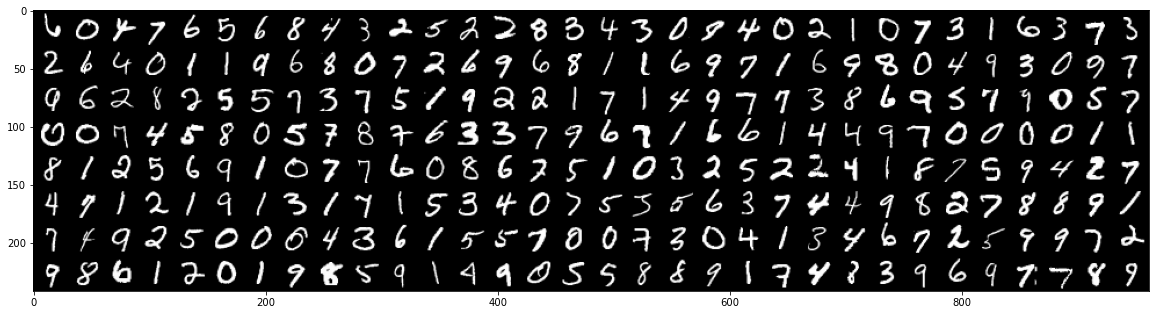

In [5]:
#Lets visualise an entire batch of images!
plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(images, 32)
plt.imshow(out.numpy().transpose((1, 2, 0)))

## Define our Neural Network Model 
We define our model using the torch.nn.Module class

In [6]:
#Lets create a simple MLP network similar to the sine wave approximator
class Simple_MLP(nn.Module):
    def __init__(self, num_classes):
        super(Simple_MLP, self).__init__()
        #We will use 4 linear layers
        #The input to the model is 784 (28x28 - the image size)
        #and the should be num_classes outputs
        self.fc1 = nn.Linear(784, 512)##TO DO-  hidded layer size 512 ##
        self.fc2 = nn.Linear(512, 256)##TO DO-  hidded layer size 256 ##
        self.fc3 = nn.Linear(256, 128)##TO DO-  hidded layer size 128 ##
        self.fc4 = nn.Linear(128, num_classes)##TO DO-  output layer size num_classes ##

    def forward(self, x):
        #the data we pass the model is a batch of single channel images
        #with shape BSx1x28x28 we need to flatten it to BSx784
        #To use it in a linear layer
        x = x.view(x.shape[0], -1)
        
        #We will use a relu activation function for this network! (F.relu())
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

<h3> Create the model and define the Loss and Optimizer</h3>
Since this is a classification task, we will use Cross Entropy Loss. We define our criterion using Cross Entropy Loss 

[torch.nn.CrossEntropyLoss](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)

Just like in the sine wave approximation, experiment with different optimizers and hyperparameters 

In [20]:
#Create our model
model = Simple_MLP(10).to(device)
#Create our loss function
criterion = torch.nn.CrossEntropyLoss()
#Define our loss funcition and optimizer
lr = 1e-2
optimizer = optim.SGD(model.parameters(), lr=lr)

#We can print out our model structure
print(model)
#Note: this is only the order in which the layers were defined NOT the path of the forward pass!

Simple_MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


<h3> Create a function that will train the network for one epoch </h3>

In [21]:
def train_epoch(model, train_loader, criterion, optimizer, loss_logger):
    for batch_idx, (data, target) in enumerate(train_loader):   
        #forward pass of model
        outputs = model(data.to(device))
        
        #calculate loss
        loss = criterion(outputs, target.to(device))
        
        #Zero gradients
        optimizer.zero_grad()
        
        #Backprop loss
        loss.backward()
        
        #Optimization Step
        optimizer.step()
        
        loss_logger.append(loss.item())

    return loss_logger

<h3> Create a function that will evaluate our network's performance on the test set </h3>

In [22]:
def test_model(model, test_loader, criterion, loss_logger):
    with torch.no_grad():
        correct_predictions = 0
        total_predictions = 0
        for batch_idx, (data, target) in enumerate(test_loader):   
            #forward pass of model
            outputs =model(data.to(device))           
            
            #Calculate the accuracy of the model
            #you'll need to accumulate the accuracy over multiple steps
            #print(torch.argmax(outputs, 1).shape)
            #print(target.shape)
            ##TO DO## 
            _, predicted = torch.max(outputs, 1)
            #Number of correctly predicted outputs
            correct_predictions += (predicted == target.to(device)).sum().item()
            #total number of predictions made
            total_predictions += target.shape[0]
            
            #calculate the loss
            loss = loss = criterion(outputs, target.to(device))
            loss_logger.append(loss.item())
            
        acc = (correct_predictions/total_predictions)*100.0
        return loss_logger, acc

## Train the model for N epochs
We call our training and testing functions in a loop, while keeping track of the losses and accuracy. 

In [23]:
n_epochs = 20
train_loss = []
test_loss  = []
test_acc   = []

In [24]:
for i in range(n_epochs):
    clear_output(True)
    print("Epoch: [%d/%d]" % (i+1, n_epochs))
    
    train_loss = train_epoch(model, train_loader, criterion, optimizer, train_loss)
    test_loss, acc = test_model(model, test_loader, criterion, test_loss)
    test_acc.append(acc)

print("Final Accuracy: %.2f%%" % acc)

Epoch: [20/20]
Final Accuracy: 91.85%


## Visualize Training Data

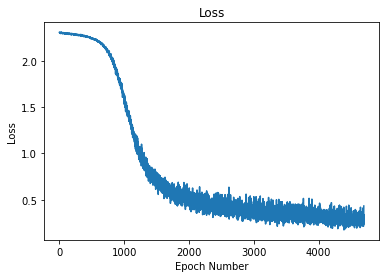

In [25]:
plt.title('Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(train_loss)

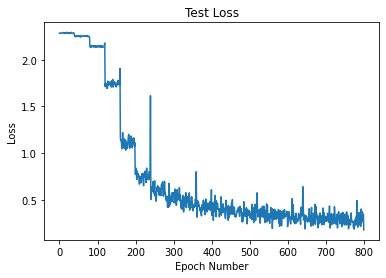

In [26]:
plt.title('Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(test_loss)

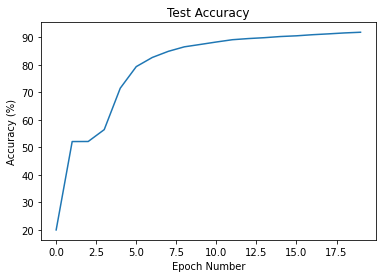

In [27]:
plt.title('Test Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.plot(test_acc)